# M5 Accuracy: Keras with Categorical Embeddings

This notebook tries to model expected sales of product groups. Since many of the features are categorical, we use this example to show how embedding layers make life easy when dealing with categoric inputs for neural nets, even if the number of rows is high.

THIS IS WORK IN PROGRESS: Currently, the most urgent issue is to add a reasonable amount of time shifted features.

Like for other recent competitions, keeping memory below 13 GB is a challenge.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os

## Load data

In [2]:
path = "../input/m5-forecasting-accuracy"
calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))

In [3]:
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

## Describe and prepare data

We will now go through all four data sets and prepare them for modelling.

### Calendar data

For each date (covering both training and test data), we have access to useful calendar information.

In [4]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


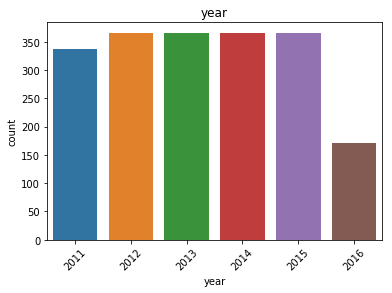

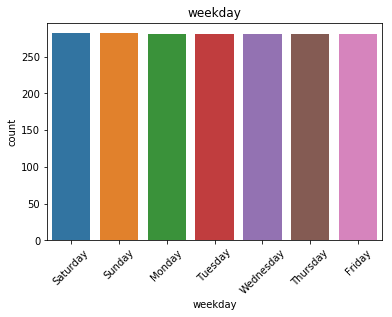

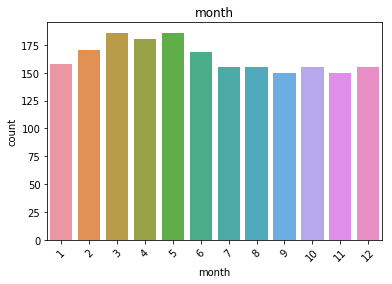

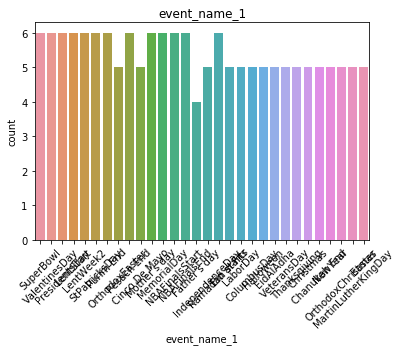

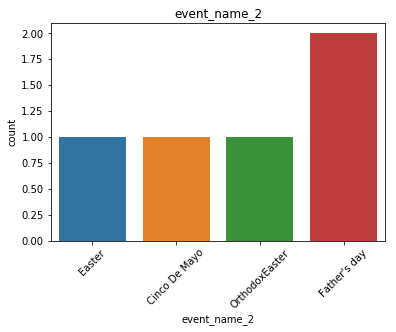

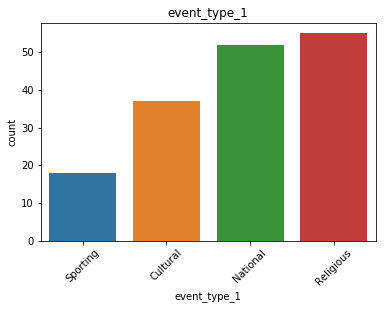

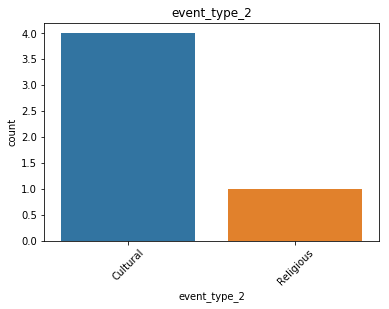

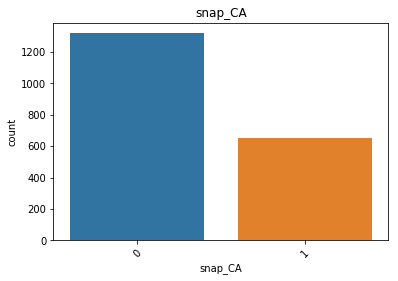

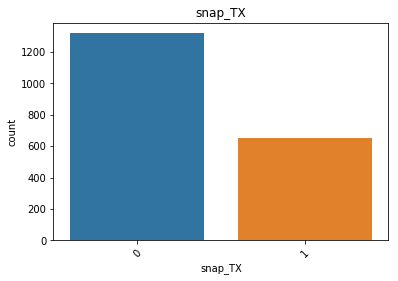

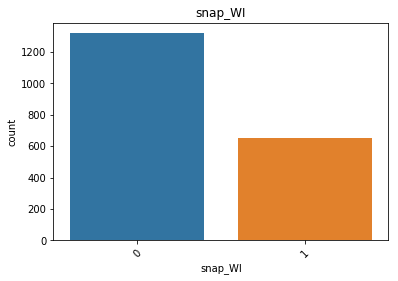

In [5]:
for i, var in enumerate(["year", "weekday", "month", "event_name_1", "event_name_2", 
                         "event_type_1", "event_type_2", "snap_CA", "snap_TX", "snap_WI"]):
    plt.figure()
    g = sns.countplot(calendar[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

In [6]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    temp = ["wday", "month", "year", "event_name_1", "event_type_1", "event_name_2", 
            "event_type_2", "snap_CA", "snap_TX", "snap_WI"]
    df = df[["wm_yr_wk", "d"] + temp]
    df.fillna("missing", inplace=True)
    df[temp] = OrdinalEncoder().fit_transform(df[temp])
    for v in temp:
        df[temp] = df[temp].astype("uint8")
    df.wm_yr_wk = df.wm_yr_wk.astype("uint16")
    return df

calendar = prep_calendar(calendar)

In [7]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 12 columns):
wm_yr_wk        1969 non-null uint16
d               1969 non-null object
wday            1969 non-null uint8
month           1969 non-null uint8
year            1969 non-null uint8
event_name_1    1969 non-null uint8
event_type_1    1969 non-null uint8
event_name_2    1969 non-null uint8
event_type_2    1969 non-null uint8
snap_CA         1969 non-null uint8
snap_TX         1969 non-null uint8
snap_WI         1969 non-null uint8
dtypes: object(1), uint16(1), uint8(10)
memory usage: 38.6+ KB


#### Notes for modeling

**Features** deemed to be useful:

- wday -> integer coding & embedding

- year(?) -> integer coding & embedding

- month(?) -> integer coding & embedding

- "event_name_1", "event_type_1"": simple imputer & integer coding & embedding

**Reshape required**: No

**Merge key(s)**: "d", "wm_yr_wk"

### Sales data

Contains the number of sold items (= our response) as well as some categorical features.

In [8]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


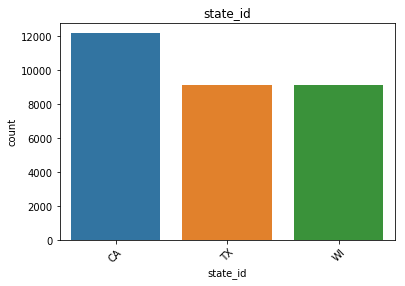

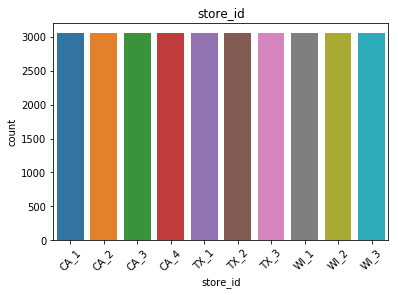

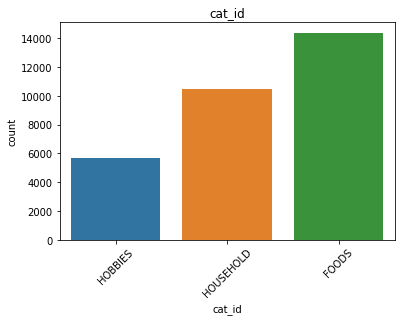

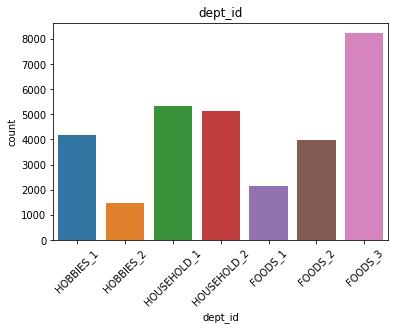

In [9]:
for i, var in enumerate(["state_id", "store_id", "cat_id", "dept_id"]):
    plt.figure()
    g = sns.countplot(sales[var])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set_title(var)

In [10]:
sales.item_id.value_counts()

HOUSEHOLD_2_081    10
HOUSEHOLD_1_164    10
FOODS_1_109        10
FOODS_3_718        10
HOUSEHOLD_1_251    10
                   ..
HOUSEHOLD_2_398    10
FOODS_3_119        10
FOODS_1_169        10
HOBBIES_1_285      10
FOODS_2_367        10
Name: item_id, Length: 3049, dtype: int64

#### Drop dates to save space. Offline, this is not required.

In [11]:
sales.drop(["d_" + str(i+1) for i in range(800)], axis=1, inplace=True)

#### Reshaping

We now reshape the data from wide to long, using "id" as fixed and swapping "d_x" columns. 

In [12]:
def melt_sales(df):
    df = df.drop(["item_id", "dept_id", "cat_id", "store_id", "state_id"], axis=1).melt(
        id_vars=['id'], var_name='d', value_name='demand')
    return df

sales = melt_sales(sales)

In [13]:
sales.head()

,id,d,demand
0,HOBBIES_1_001_CA_1_validation,d_801,0
1,HOBBIES_1_002_CA_1_validation,d_801,0
2,HOBBIES_1_003_CA_1_validation,d_801,0
3,HOBBIES_1_004_CA_1_validation,d_801,0
4,HOBBIES_1_005_CA_1_validation,d_801,0


#### Distribution of the response

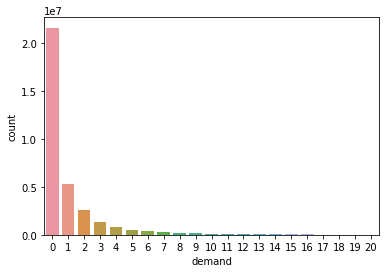

In [14]:
sns.countplot(sales["demand"][sales["demand"] <= 20], );

#### Add reshaped submission file

So that it sneaks through data preprocessing easily.

In [15]:
sample_submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Turn strings like "F1" to "d_1914"
def map_f2d(d_col, id_col):
    eval_flag = id_col.str.endswith("evaluation")
    return "d_" + (d_col.str[1:].astype("int") + 1913 + 28 * eval_flag).astype("str")

# Reverse
def map_d2f(d_col, id_col):
    eval_flag = id_col.str.endswith("evaluation")
    return "F" + (d_col.str[2:].astype("int") - 1913 - 28 * eval_flag).astype("str")

# Example
map_f2d(pd.Series(["F1", "F2", "F28", "F1", "F2", "F28"]), 
        pd.Series(["validation", "validation", "validation", "evaluation", "evaluation", "evaluation"]))

0    d_1914
1    d_1915
2    d_1941
3    d_1942
4    d_1943
5    d_1969
dtype: object

In [17]:
submission = sample_submission.melt(id_vars="id", var_name="d", value_name="demand").assign(
    demand=np.nan,
    d = lambda df: map_f2d(df.d, df.id))
submission.head()

,id,d,demand
0,HOBBIES_1_001_CA_1_validation,d_1914,NaN
1,HOBBIES_1_002_CA_1_validation,d_1914,NaN
2,HOBBIES_1_003_CA_1_validation,d_1914,NaN
3,HOBBIES_1_004_CA_1_validation,d_1914,NaN
4,HOBBIES_1_005_CA_1_validation,d_1914,NaN


In [18]:
sales = pd.concat([sales, submission])
sales.tail()

,id,d,demand
1707435,FOODS_3_823_WI_3_evaluation,d_1969,NaN
1707436,FOODS_3_824_WI_3_evaluation,d_1969,NaN
1707437,FOODS_3_825_WI_3_evaluation,d_1969,NaN
1707438,FOODS_3_826_WI_3_evaluation,d_1969,NaN
1707439,FOODS_3_827_WI_3_evaluation,d_1969,NaN


#### Change "evaluation" to "validation"...

In [19]:
sales.id = sales.id.str.replace("evaluation", "validation")

#### Add lag info

We use some lagged features similar to https://www.kaggle.com/ragnar123/very-fst-model, but shifted by 56 instead of 28 days. Furthermore, we work with log values.

Furthermore, we remove the first 800 days to save space. In offline mode, we can use all rows.

In [20]:
from sklearn.preprocessing import StandardScaler

def add_lagged_features(df):
    df['lag_t56'] = df.groupby('id')['demand'].transform(lambda x: np.log1p(x).shift(56))
    df['rolling_mean_t30'] = df.groupby('id')['demand'].transform(lambda x: np.log1p(x).shift(56).rolling(30, min_periods=1).mean())
    df['cummean'] = df.groupby('id')['demand'].transform(lambda x: x.shift(1).expanding().mean())
    temp = ['lag_t56', 'rolling_mean_t30', 'cummean']
    df.dropna(subset=temp, inplace=True)    
    df[temp] = StandardScaler().fit_transform(df[temp])
    for v in temp:
        df[v] = df[v].astype("float32")
    return df

sales = add_lagged_features(sales)

In [21]:
sales.head()

,id,d,demand,lag_t56,rolling_mean_t30,cummean
1707440,HOBBIES_1_001_CA_1_validation,d_857,0.0,-0.634819,-0.823925,-0.396836
1707441,HOBBIES_1_002_CA_1_validation,d_857,1.0,-0.634819,-0.823925,-0.331548
1707442,HOBBIES_1_003_CA_1_validation,d_857,0.0,-0.634819,-0.823925,-0.396836
1707443,HOBBIES_1_004_CA_1_validation,d_857,0.0,-0.634819,-0.823925,0.161084
1707444,HOBBIES_1_005_CA_1_validation,d_857,0.0,-0.634819,-0.823925,-0.106005


In [22]:
gc.collect()

0

#### Add relevant id information

After combination of training and test data, we can join further info.

In [23]:
def expand_id(id):
    return id.str.split("_", expand=True).assign(
        dept_id=lambda df: df.iloc[:,0] + "_" + df.iloc[:,1], 
        item_id=lambda df: df.iloc[:,0] + "_" + df.iloc[:,1] + "_" + df.iloc[:, 2],
        store_id=lambda df: df.iloc[:,3] + "_" + df.iloc[:,4]).drop(np.arange(6), axis=1)

# Example
expand_id(sales["id"].head())

,dept_id,item_id,store_id
1707440,HOBBIES_1,HOBBIES_1_001,CA_1
1707441,HOBBIES_1,HOBBIES_1_002,CA_1
1707442,HOBBIES_1,HOBBIES_1_003,CA_1
1707443,HOBBIES_1,HOBBIES_1_004,CA_1
1707444,HOBBIES_1,HOBBIES_1_005,CA_1


In [24]:
uid = pd.Series(sales["id"].unique())
id_lookup = expand_id(uid)
id_lookup["id"] = uid

encode_item_id = OrdinalEncoder()
encode_dept_id = OrdinalEncoder()
encode_store_id = OrdinalEncoder()
id_lookup["item_id"] = encode_item_id.fit_transform(id_lookup[["item_id"]]).astype("uint16")
id_lookup["dept_id"] = encode_dept_id.fit_transform(id_lookup[["dept_id"]]).astype("uint8")
id_lookup["store_id"] = encode_store_id.fit_transform(id_lookup[["store_id"]]).astype("uint8")

id_lookup.head()

,dept_id,item_id,store_id,id
0,3,1437,0,HOBBIES_1_001_CA_1_validation
1,3,1438,0,HOBBIES_1_002_CA_1_validation
2,3,1439,0,HOBBIES_1_003_CA_1_validation
3,3,1440,0,HOBBIES_1_004_CA_1_validation
4,3,1441,0,HOBBIES_1_005_CA_1_validation


In [25]:
sales = sales.merge(id_lookup, on="id", how="left")
del sales["id"]

In [26]:
sales.head()

,d,demand,lag_t56,rolling_mean_t30,cummean,dept_id,item_id,store_id
0,d_857,0.0,-0.634819,-0.823925,-0.396836,3,1437,0
1,d_857,1.0,-0.634819,-0.823925,-0.331548,3,1438,0
2,d_857,0.0,-0.634819,-0.823925,-0.396836,3,1439,0
3,d_857,0.0,-0.634819,-0.823925,0.161084,3,1440,0
4,d_857,0.0,-0.634819,-0.823925,-0.106005,3,1441,0


In [27]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33935370 entries, 0 to 33935369
Data columns (total 8 columns):
d                   object
demand              float64
lag_t56             float32
rolling_mean_t30    float32
cummean             float32
dept_id             uint8
item_id             uint16
store_id            uint8
dtypes: float32(3), float64(1), object(1), uint16(1), uint8(2)
memory usage: 1.3+ GB


#### Notes for modeling

**Features**

- dept_id: Integer coding & embedding

- item_id: Integer coding & embedding

- store_id: Integer coding & embedding

- lag & rolling mean

**Reshape**:

- Reshape days as "d" from wide to long -> "demand" will be response variable

**Merges**:

1. Join calendar features by "d" in format "d_1"

2. Join selling prices by "store_id", "item_id" and ("wm_yr_wk" from calendar)

Comment: Out-of-sample dates: "d_1914" - "d_1969"

### Selling prices

Contains selling prices for each store_id, item_id_wm_yr_wk combination.

In [28]:
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


Derive some time related features:

In [29]:
# Add relative change
def prep_selling_prices(df):
    df = df.copy()
    df["store_id"] = encode_store_id.transform(df[["store_id"]]).astype("uint8")
    df["item_id"] = encode_item_id.transform(df[["item_id"]]).astype("uint16")
    df["wm_yr_wk"] = df["wm_yr_wk"].astype("uint16")
    
    df["sell_price_rel_diff"] = df.groupby(["store_id", "item_id"])["sell_price"].pct_change()
    sell_price_cummin = df.groupby(["store_id", "item_id"])["sell_price"].cummin()
    sell_price_cummax = df.groupby(["store_id", "item_id"])["sell_price"].cummax()
    df["sell_price_cumrel"] = (df["sell_price"] - sell_price_cummin) / (sell_price_cummax - sell_price_cummin)
    df.fillna({"sell_price_rel_diff": 0, "sell_price_cumrel": 1}, inplace=True)
    floats = ["sell_price_cumrel", "sell_price_rel_diff", "sell_price"]
    sc = StandardScaler()
    df[floats] = sc.fit_transform(df[floats])
    for v in floats:
        df[v] = df[v].astype("float32")
    return df

selling_prices = prep_selling_prices(selling_prices)

In [30]:
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff,sell_price_cumrel
0,0,1437,11325,1.516377,-0.002756,0.521493
1,0,1437,11326,1.516377,-0.002756,0.521493
2,0,1437,11327,1.129146,-0.309145,-2.195864
3,0,1437,11328,1.129146,-0.002756,-2.195864
4,0,1437,11329,1.129146,-0.002756,-2.195864


#### Notes for modeling

**Features**:

- sell_price: numeric

- relative change to last date (per store and item): numeric

- price position between cummin and cummax (per store and item): numeric

**Reshape**: No

**Merge key(s)**: to sales data by store_id, item_id, wm_yr_wk (through calendar data)

### Combine all

In [31]:
gc.collect()
sales = sales.merge(calendar, how="left", on="d")
del sales["d"]

In [32]:
gc.collect()
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
del sales["wm_yr_wk"]

In [33]:
sales.fillna({"sell_price": 0, "sell_price_rel_diff": 0, "sell_price_cumrel": 0}, inplace=True)

In [34]:
gc.collect()

0

## Modelling

We will now use Tensorflow & Keras to model sales demand as a function of the prepared input. Key pieces are the categorical predictors prepared above. They will be fed through embedding layers and combined to dense numeric features.

For simplicity, we use MSE as evaluation criterion. This will most certainly change in future commits.

### Create input dicts for multi-input

In [35]:
training_flag = pd.notna(sales.demand)

In [36]:
def make_Xy(df, ind=None, return_y = True):
    if ind is not None:
        df = df[ind]
    X = {"dense1": df[["lag_t56", "rolling_mean_t30", "cummean",
                       "snap_CA", "snap_TX", "snap_WI",
                       "sell_price", "sell_price_rel_diff", 
                       "sell_price_cumrel"]].to_numpy(dtype="float32"),
         "item_id": df[["item_id"]].to_numpy(dtype="uint16")}
    for i, v in enumerate(["wday", "month", "year", "event_name_1", 
                           "event_type_1", "dept_id", "store_id"]):
        X[v] = df[[v]].to_numpy(dtype="uint8")
    if return_y:
        return X, df.demand.to_numpy(dtype="float32")
    else:
        return X

In [37]:
X_train, y_train = make_Xy(sales, training_flag) # make_Xy(sales[0:1000000])
y_train.shape

(32227930,)

In [38]:
X_test = make_Xy(sales, ~training_flag, return_y=False)

In [39]:
del sales
gc.collect()

0

### The model

In [40]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [41]:
# Dense part
dense_input = Input(shape=(9, ), name='dense1')
dense_branch = Dense(100, activation="relu")(dense_input)
#dense_branch = Dense(100, activation="relu")(dense_branch)

# Embedded input
wday_input = Input(shape=(1,), name='wday')
month_input = Input(shape=(1,), name='month')
year_input = Input(shape=(1,), name='year')
event_name_1_input = Input(shape=(1,), name='event_name_1')
event_type_1_input = Input(shape=(1,), name='event_type_1')
event_name_2_input = Input(shape=(1,), name='event_name_2')
event_type_2_input = Input(shape=(1,), name='event_type_2')
item_id_input = Input(shape=(1,), name='item_id')
dept_id_input = Input(shape=(1,), name='dept_id')
store_id_input = Input(shape=(1,), name='store_id')

# Embedding layers
wday_emb = Flatten()(Embedding(7, 2)(wday_input))
month_emb = Flatten()(Embedding(12, 2)(month_input))
year_emb = Flatten()(Embedding(6, 2)(year_input))
event_name_1_emb = Flatten()(Embedding(31, 5)(event_name_1_input))
event_type_1_emb = Flatten()(Embedding(5, 2)(event_type_1_input))
event_name_2_emb = Flatten()(Embedding(5, 2)(event_name_2_input))
event_type_2_emb = Flatten()(Embedding(5, 2)(event_type_2_input))
item_id_emb = Flatten()(Embedding(len(encode_item_id.categories_[0]), 30)(item_id_input))
item_id_emb = Dropout(0.3)(item_id_emb)
dept_id_emb = Flatten()(Embedding(7, 2)(dept_id_input))
store_id_emb = Flatten()(Embedding(10, 2)(store_id_input))

x = concatenate([dense_branch, wday_emb, month_emb, year_emb, event_name_1_emb,
                event_type_1_emb, item_id_emb, dept_id_emb, store_id_emb])
x = Dense(150, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
prediction = Dense(1, activation="linear", name='output')(x)

model = Model(inputs={"dense1": dense_input, "wday": wday_input, "month": month_input,
                      "year": year_input, "event_name_1": event_name_1_input, "event_type_1": event_type_1_input,
                      "item_id": item_id_input, "dept_id": dept_id_input, "store_id": store_id_input},
              outputs=prediction)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
wday (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
year (InputLayer)               [(None, 1)]          0                                            
______________________________________________________________________________________________

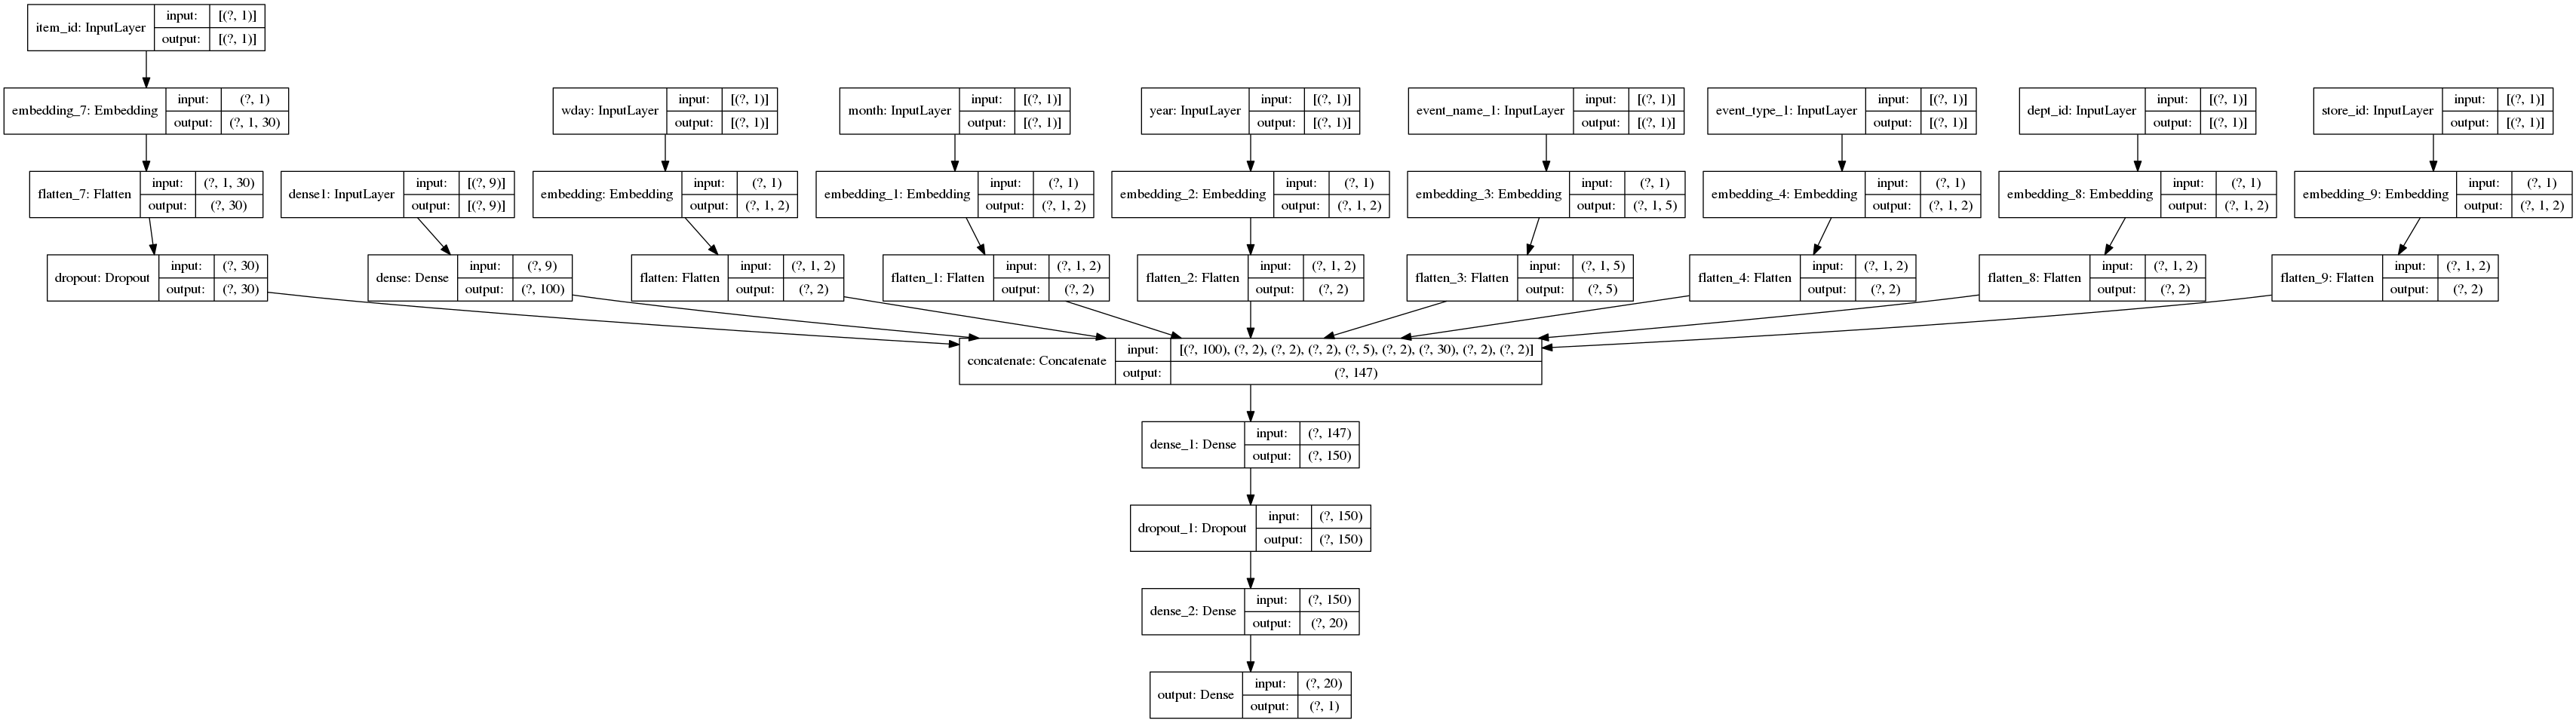

In [42]:
model.summary()

keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [43]:
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['mse'])

history = model.fit(X_train, 
                    y_train,
                    batch_size=4096,
                    epochs=3,
                    validation_split=0.1)

Train on 29005137 samples, validate on 3222793 samples
Epoch 1/3
29005137/29005137 [==============================] - 100s 3us/sample - loss: 6.3064 - mse: 6.3064 - val_loss: 5.8413 - val_mse: 5.8413
Epoch 2/3
29005137/29005137 [==============================] - 93s 3us/sample - loss: 5.9682 - mse: 5.9682 - val_loss: 5.6987 - val_mse: 5.6987
Epoch 3/3
29005137/29005137 [==============================] - 94s 3us/sample - loss: 5.8116 - mse: 5.8116 - val_loss: 5.7041 - val_mse: 5.7041


#### Plot the evaluation metrics over epochs

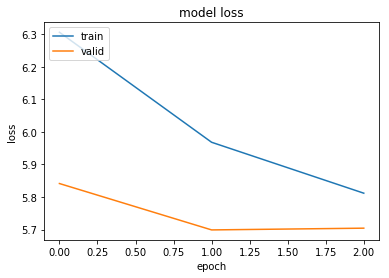

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [45]:
model.save('model.h5')

## Submission

In [46]:
pred = model.predict(X_test, batch_size=4096)

In [47]:
pred.shape

(1707440, 1)

In [48]:
submission.shape

(1707440, 3)

In [49]:
submission.tail()

,id,d,demand
1707435,FOODS_3_823_WI_3_evaluation,d_1969,NaN
1707436,FOODS_3_824_WI_3_evaluation,d_1969,NaN
1707437,FOODS_3_825_WI_3_evaluation,d_1969,NaN
1707438,FOODS_3_826_WI_3_evaluation,d_1969,NaN
1707439,FOODS_3_827_WI_3_evaluation,d_1969,NaN


In [50]:
submission = submission.assign(
    demand = np.clip(pred, 0, None),
    d = lambda df: map_d2f(df.d, df.id))
submission.head()

,id,d,demand
0,HOBBIES_1_001_CA_1_validation,F1,0.847336
1,HOBBIES_1_002_CA_1_validation,F1,0.357610
2,HOBBIES_1_003_CA_1_validation,F1,0.381776
3,HOBBIES_1_004_CA_1_validation,F1,1.454668
4,HOBBIES_1_005_CA_1_validation,F1,0.988972


In [51]:
# Right column order
col_order = ["id"] + ["F" + str(i + 1) for i in range(28)]
submission = submission.pivot(index="id", columns="d", values="demand").reset_index()[col_order]

# Right row order
submission = sample_submission[["id"]].merge(submission, how="left", on="id")

In [52]:
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.847336,0.748217,0.747773,0.770394,0.907941,0.939398,0.950653,0.689453,0.807428,...,1.064007,1.229876,1.216835,0.833451,0.749901,0.739769,0.745419,0.908792,1.171279,1.079349
1,HOBBIES_1_002_CA_1_validation,0.357610,0.330867,0.337055,0.385401,0.381446,0.407414,0.462637,0.407427,0.401066,...,0.405219,0.411174,0.405286,0.355804,0.338590,0.335249,0.342667,0.370161,0.400636,0.385715
2,HOBBIES_1_003_CA_1_validation,0.381776,0.365093,0.361831,0.452285,0.542887,0.485546,0.502270,0.436046,0.414526,...,0.411858,0.431013,0.402590,0.357710,0.375771,0.429028,0.450044,0.486595,0.562319,0.612096
3,HOBBIES_1_004_CA_1_validation,1.454668,1.274514,1.247142,1.664778,1.648319,1.307862,1.644146,1.574306,1.411124,...,1.777993,1.397659,2.379503,1.704281,1.651905,1.547178,1.694915,1.708566,2.049847,2.458474
4,HOBBIES_1_005_CA_1_validation,0.988972,0.976811,0.905296,0.913987,1.086625,1.128691,1.259224,1.152157,1.094864,...,1.276878,1.568531,1.619322,1.049411,0.993987,1.000323,1.007020,1.055015,1.402471,1.445481


In [53]:
submission.to_csv("submission.csv", index=False)